In [ ]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Configuration
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "Converted Images"
OUT_DIR = PROJECT_ROOT / "outputs"
PREP_DIR = OUT_DIR / "preprocessed_index" 
PREP_DIR.mkdir(parents=True, exist_ok=True)
INDEX_CSV = OUT_DIR / "preprocessed_index.csv"

# Image extensions
EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# Preprocessing parameters
RESIZE_MODE = "fixed300"  # Options: "fixed300", "fixed256", "width480"
FIXED_SIZE = (300, 300)
TARGET_WIDTH = 480

# Gaussian blur
GAUSS_KSIZE = (5, 5)
GAUSS_SIGMA = 0

# Gamma correction
GAMMA = 1.2

# CLAHE parameters
CLAHE_CLIP = 2.0
CLAHE_TILE = (8, 8)

# 1. Scan Dataset & Binary Labeling

In [ ]:
def scan_dataset(root: Path):
    rows = []
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        cls = cls_dir.name
        for fp in cls_dir.rglob("*"):
            if fp.is_file() and fp.suffix.lower() in EXTS:
                # Healthy = 0, else/diseased = 1
                y = 0 if cls.lower() == "healthy" else 1
                rows.append({
                    "orig_path": str(fp),
                    "class": cls,
                    "Output": y,
                })
    return pd.DataFrame(rows)

df = scan_dataset(DATA_DIR)
print("DATA_DIR:", DATA_DIR)
print("Total images:", len(df))
df.head()


DATA_DIR: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\data\Converted Images
Total images: 724


,orig_path,class,Output
0,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1
1,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1
2,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1
3,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1
4,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1


# 5. Alternative Preprocessing Methods (Optional)

You can experiment with different preprocessing strategies by changing the `preprocess_fn` parameter in `process_dataset()`. Available methods:
- `preprocess_basic` - Gaussian blur + Gamma correction + Histogram equalization
- `preprocess_clahe` - CLAHE enhancement + Sharpening
- `preprocess_saturation` - HSV saturation channel extraction
- `preprocess_edge` - Canny edge detection
- `preprocess_morphological` - Morphological opening for noise removal

# 2. Preprocessing Functions

In [ ]:
def resize_fixed(gray: np.ndarray, size_wh: tuple = FIXED_SIZE) -> np.ndarray:
    """Resize to fixed size using INTER_AREA."""
    return cv2.resize(gray, size_wh, interpolation=cv2.INTER_AREA)

def resize_keep_aspect_width(gray: np.ndarray, target_width: int = TARGET_WIDTH, 
                             allow_upscale: bool = True) -> np.ndarray:
    """Resize keeping aspect ratio, scaling to target width."""
    h, w = gray.shape[:2]
    if w == target_width:
        return gray
    if (w < target_width) and (not allow_upscale):
        return gray
    scale = target_width / float(w)
    new_h = int(round(h * scale))
    return cv2.resize(gray, (target_width, new_h), interpolation=cv2.INTER_AREA)

def resize_image(bgr: np.ndarray) -> np.ndarray:
    """Resize image based on RESIZE_MODE config."""
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    if RESIZE_MODE == "fixed300":
        return resize_fixed(gray, FIXED_SIZE)
    elif RESIZE_MODE == "fixed256":
        return resize_fixed(gray, (256, 256))
    elif RESIZE_MODE == "width480":
        return resize_keep_aspect_width(gray, TARGET_WIDTH, allow_upscale=True)
    else:
        raise ValueError(f"Unknown RESIZE_MODE: {RESIZE_MODE}")

def apply_gaussian_blur(gray: np.ndarray) -> np.ndarray:
    """Apply Gaussian blur for denoising."""
    return cv2.GaussianBlur(gray, GAUSS_KSIZE, GAUSS_SIGMA)

def apply_gamma_correction(img: np.ndarray, gamma: float = GAMMA) -> np.ndarray:
    """Apply gamma correction to image."""
    if gamma <= 0:
        return img
    inv = 1.0 / gamma
    table = (np.arange(256) / 255.0) ** inv
    table = np.clip(table * 255.0, 0, 255).astype(np.uint8)
    return cv2.LUT(img, table)

def apply_histogram_equalization(gray: np.ndarray) -> np.ndarray:
    """Apply histogram equalization."""
    return cv2.equalizeHist(gray)

def apply_clahe(gray: np.ndarray, clip_limit: float = CLAHE_CLIP, 
                tile_grid: tuple = CLAHE_TILE) -> np.ndarray:
    """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid)
    return clahe.apply(gray)

def apply_sharpening(img: np.ndarray) -> np.ndarray:
    """Apply sharpening filter."""
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def apply_morphological_opening(gray: np.ndarray, kernel_size: tuple = (3, 3)) -> np.ndarray:
    """Apply morphological opening to remove noise."""
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    return cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

def apply_canny_edge(gray: np.ndarray, threshold1: int = 100, threshold2: int = 200) -> np.ndarray:
    """Apply Canny edge detection."""
    return cv2.Canny(gray, threshold1, threshold2)

def preprocess_basic(bgr: np.ndarray) -> np.ndarray:
    """Basic preprocessing: resize + gaussian + gamma + histogram eq."""
    gray = resize_image(bgr)
    gray = apply_gaussian_blur(gray)
    gray = apply_gamma_correction(gray)
    gray = apply_histogram_equalization(gray)
    return gray

def preprocess_clahe(bgr: np.ndarray) -> np.ndarray:
    """Preprocessing with CLAHE: resize + gaussian + clahe + sharpening."""
    gray = resize_image(bgr)
    gray = apply_gaussian_blur(gray)
    gray = apply_clahe(gray)
    gray = apply_sharpening(gray)
    return gray

def preprocess_saturation(bgr: np.ndarray) -> np.ndarray:
    """Extract HSV saturation channel + CLAHE."""
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    s_channel = hsv[:, :, 1]
    s_channel = resize_fixed(s_channel, FIXED_SIZE)
    s_channel = apply_clahe(s_channel)
    return s_channel

def preprocess_edge(bgr: np.ndarray) -> np.ndarray:
    """Extract edges using Canny + resize."""
    gray = resize_image(bgr)
    gray = apply_gaussian_blur(gray)
    gray = apply_canny_edge(gray)
    return gray

def preprocess_morphological(bgr: np.ndarray) -> np.ndarray:
    """Preprocessing with morphological operations."""
    gray = resize_image(bgr)
    gray = apply_clahe(gray)
    gray = apply_morphological_opening(gray)
    return gray

# 3. Processing & Save

In [ ]:
def get_output_path(input_path: str, cls: str, prep_dir: Path = PREP_DIR) -> Path:
    """Get output file path for preprocessed image."""
    input_p = Path(input_path)
    class_dir = prep_dir / cls
    class_dir.mkdir(parents=True, exist_ok=True)
    return class_dir / input_p.name

def process_dataset(df: pd.DataFrame, preprocess_fn, prep_output_dir: Path, 
                    desc: str = "Processing") -> tuple[pd.DataFrame, int]:
    """
    Process all images in dataset using specified preprocessing function.
    
    Args:
        df: DataFrame with orig_path and class columns
        preprocess_fn: Function that takes BGR image and returns processed image
        prep_output_dir: Directory to save preprocessed images
        desc: Progress bar description
        
    Returns:
        Tuple of (processed dataframe, number of failed images)
    """
    rows = []
    failed = 0
    
    for record in tqdm(df.to_dict("records"), desc=desc):
        orig_path = record["orig_path"]
        cls = record["class"]
        y = int(record["Output"])
        
        # Read image
        bgr = cv2.imread(orig_path)
        if bgr is None:
            failed += 1
            continue
        
        # Process image
        try:
            processed = preprocess_fn(bgr)
        except Exception as e:
            print(f"Error processing {orig_path}: {e}")
            failed += 1
            continue
        
        # Save image
        output_path = get_output_path(orig_path, cls, prep_output_dir)
        success = cv2.imwrite(str(output_path), processed)
        if not success:
            failed += 1
            continue
        
        # Get dimensions
        if len(processed.shape) == 2:
            h, w = processed.shape
        else:
            h, w = processed.shape[:2]
        
        rows.append({
            "orig_path": orig_path,
            "prep_path": str(output_path),
            "class": cls,
            "Output": y,
            "width": w,
            "height": h,
            "resize_mode": RESIZE_MODE,
        })
    
    return pd.DataFrame(rows), failed

# Run preprocessing with basic method
output_csv = OUT_DIR / "preprocessed_index.csv"
df_processed, failed_count = process_dataset(df, preprocess_basic, PREP_DIR, 
                                             desc="Preprocessing (basic)")

# Save results
df_processed.to_csv(output_csv, index=False)

print(f"✓ Preprocessed images saved to: {PREP_DIR}")
print(f"✓ Index CSV saved to: {output_csv}")
print(f"✓ Processed: {len(df_processed)} | Failed: {failed_count}")
print(f"\nDataFrame shape: {df_processed.shape}")
df_processed.head()

Preprocessing (paper): 100%|██████████| 724/724 [00:01<00:00, 404.26it/s]

Saved preprocessed images to: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\preprocessed_index
Index CSV: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\preprocessed_index.csv
Saved preprocessed images to: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\preprocessed_index
Index CSV: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\preprocessed_index
df_prep shape: (724, 10) | failed: 0


,orig_path,prep_path,class,Output,width,height,resize_mode,gaussian,gamma,equalization
0,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1,300,300,fixed300_bilinear,"(5, 5)_sigma0",1.2,hist_eq
1,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1,300,300,fixed300_bilinear,"(5, 5)_sigma0",1.2,hist_eq
2,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1,300,300,fixed300_bilinear,"(5, 5)_sigma0",1.2,hist_eq
3,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1,300,300,fixed300_bilinear,"(5, 5)_sigma0",1.2,hist_eq
4,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,Anthracnose,1,300,300,fixed300_bilinear,"(5, 5)_sigma0",1.2,hist_eq


# 4. Visualization - Before & After

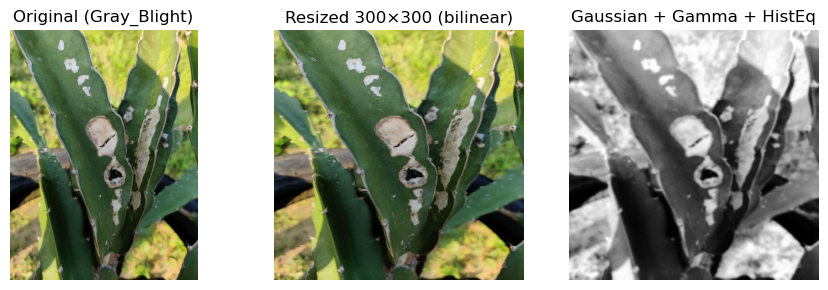

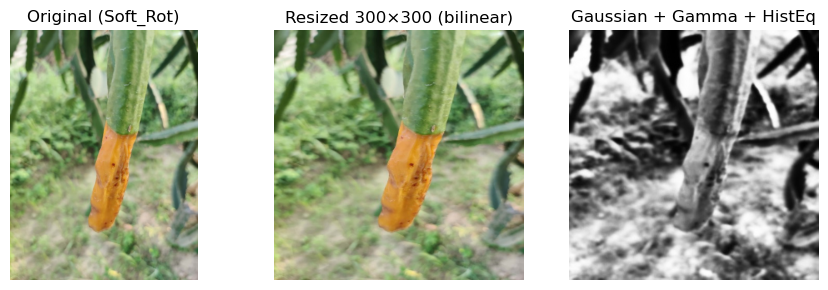

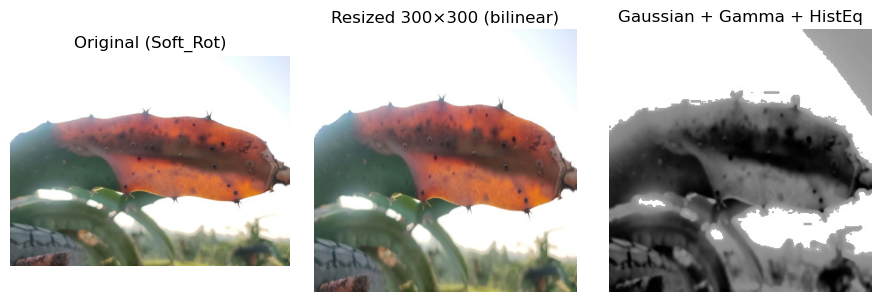

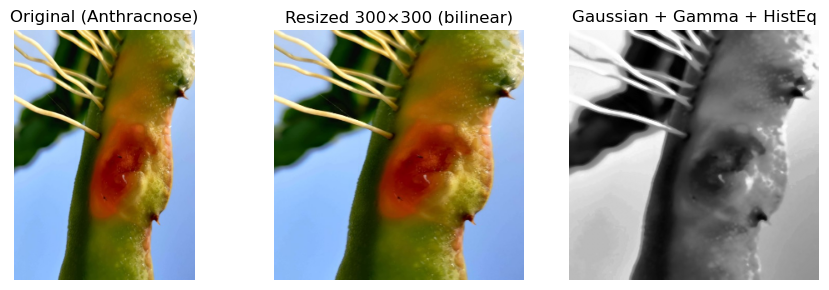

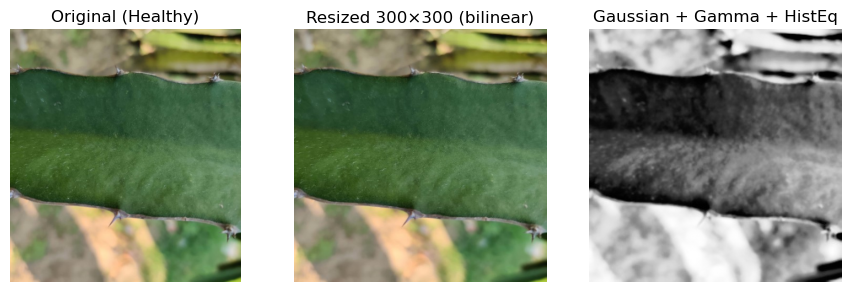

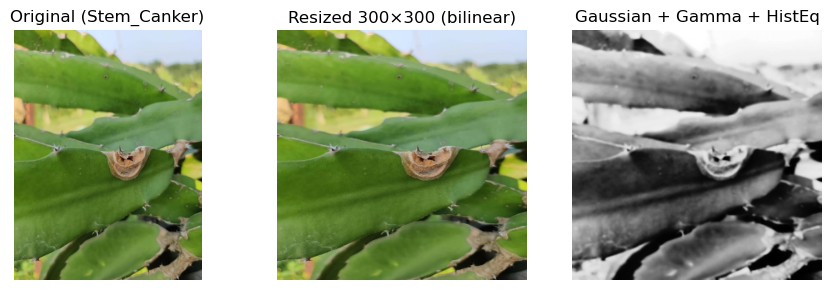

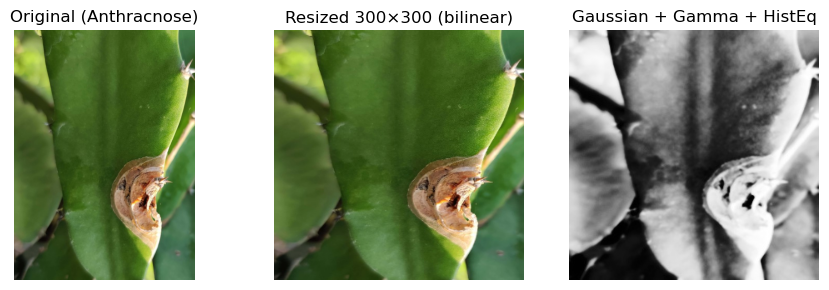

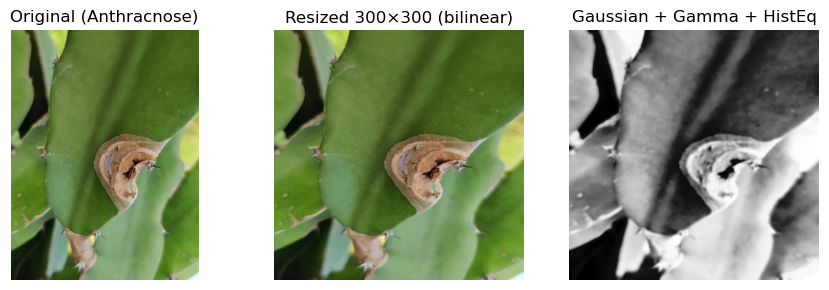

In [ ]:
def bgr_to_rgb(bgr: np.ndarray) -> np.ndarray:
    """Convert BGR to RGB color space."""
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def visualize_preprocessing_comparison(sample_df: pd.DataFrame, sample_size: int = 8):
    """Visualize original vs preprocessed images side by side."""
    sample = sample_df.sample(min(sample_size, len(sample_df)), random_state=42)
    
    for idx, record in enumerate(sample.to_dict("records"), start=1):
        orig = cv2.imread(record["orig_path"])
        prep = cv2.imread(record["prep_path"], cv2.IMREAD_GRAYSCALE)
        
        if orig is None or prep is None:
            continue
        
        # Resize original for comparison
        orig_resized = cv2.resize(orig, FIXED_SIZE, interpolation=cv2.INTER_LINEAR)
        
        # Create figure with 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))
        
        axes[0].imshow(bgr_to_rgb(orig))
        axes[0].set_title(f"Original ({record['class']})")
        axes[0].axis("off")
        
        axes[1].imshow(bgr_to_rgb(orig_resized))
        axes[1].set_title(f"Resized {FIXED_SIZE[0]}×{FIXED_SIZE[1]}")
        axes[1].axis("off")
        
        axes[2].imshow(prep, cmap="gray")
        axes[2].set_title("Preprocessed")
        axes[2].axis("off")
        
        plt.tight_layout()
        plt.show()

# Visualize sample comparisons
visualize_preprocessing_comparison(df_processed, sample_size=8)